Hi! I normalized the vote tallies for the last couple of congressional elections and normalized the values so we could see how evenly matched the 2 parties were in each district.

Citations:
```
{cite}`IG0UN2_2017`
```

In [32]:
#import geopandas and normal pandas, for plotting and dataframes
import geopandas as gpd
import pandas as pd
#plot libraries for colormaps
import matplotlib.colors as mcol
import matplotlib.cm as cm

In [33]:
#loadd the congress district map. Found this on ArcGIS, which is a third party resource granted by the clerk of the house
ly = gpd.read_file("v10/cd117.gdb/")
ly = ly[ly.STATE_ABBR != 'AK']
ly = ly[ly.STATE_ABBR != 'HI']
print(ly.head())
csv = pd.read_csv("1976-2020-house.csv")
print(csv.head())
csv = csv[csv.state_po != 'AK']
csv = csv[csv.state_po != 'HI']

  DISTRICTID STFIPS CDFIPS STATE_ABBR                NAME LAST_NAME  \
0       0101     01     01         AL          Jerry Carl      Carl   
1       0102     01     02         AL         Barry Moore     Moore   
2       0103     01     03         AL         Mike Rogers    Rogers   
3       0104     01     04         AL  Robert B. Aderholt  Aderholt   
4       0105     01     05         AL           Mo Brooks    Brooks   

        PARTY      SQMI STATE_NAME  Shape_Length  Shape_Area  \
0  Republican   6223.61    Alabama     22.189776    1.507863   
1  Republican  10260.03    Alabama     12.165162    2.528306   
2  Republican   7725.80    Alabama     10.369015    1.934011   
3  Republican   9110.93    Alabama     12.505488    2.305772   
4  Republican   3855.96    Alabama      6.859061    0.983085   

                                            geometry  
0  MULTIPOLYGON (((-88.07826 30.25212, -88.07830 ...  
1  MULTIPOLYGON (((-85.05603 32.06306, -85.05593 ...  
2  MULTIPOLYGON (((-85.

In [34]:
#add a standard code to each dataframe ex: AL1
#Note: for the MIT data {congress} the "district" column may have a leading 0. My workaround was to convert to an integer and back to string
def process(congress):
    for i, item in congress.iterrows( ):
        val = item["state_po"] + str(int(item["district"]))
        congress.at[i, "code"] = val


    for i, item in ly.iterrows():
        val = item["STATE_ABBR"] + str(int(item["CDFIPS"]))
        ly.at[i, "code"] = val

    #group by district
    grp = congress.groupby("code")
    return grp

In [35]:
def get_value(grp):
    dm = "DEMOCRAT"
    rp = "REPUBLICAN"

    #here we go. Subtract party-A from party-B and you get an either negative or positive number
    dists = [["district", "value"]]
    for name, group in grp:
        dem = group[group["party"] == dm]
        rep = group[group["party"] == rp]
        votes = dem["candidatevotes"].sum() - rep["candidatevotes"].sum()
        dists.append([name, votes])

    #we turn our list into a dataframe with the columns
    dists = pd.DataFrame(dists[1:], columns=dists[0])
    return dists

In [36]:
def normalize(dists):

    #grab the MAX value which is the max votes for party-A and Min value for Minimum value for party-B
    mx = dists["value"].max()
    mn = dists["value"].min()

    #normalize it. The value will now be between -1 and 1
    for i, row in dists.iterrows():
        if row["value"] > 0:
            dists.at[i, "value"] = (row["value"] / mx) 
        else:
            dists.at[i, "value"] = (row["value"] / mn) * -1

    #add these -1 to 1 values to our geopandas dataframe and make sure there arent any codes. Make sure that only valid districts exist. If we have to drop a row, print it

    for i, item in dists.iterrows():
        dist = item["district"]
        val = item["value"]
        if dist not in ly["code"].values:
            print(dist)
            dists.drop(i, inplace=True)
        ly.loc[ly["code"] == dist, "value"] = val 






C:\Users\AlexCunningham\AppData\Local\Temp\ipykernel_40772\3413932949.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  congress.at[i, "code"] = val


DC0


C:\Users\AlexCunningham\AppData\Local\Temp\ipykernel_40772\3413932949.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  congress.at[i, "code"] = val
C:\Users\AlexCunningham\AppData\Local\Temp\ipykernel_40772\3413932949.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  congress.at[i, "code"] = val
C:\Users\AlexCunningham\AppData\Local\Temp\ipykernel_40772\3413932949.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

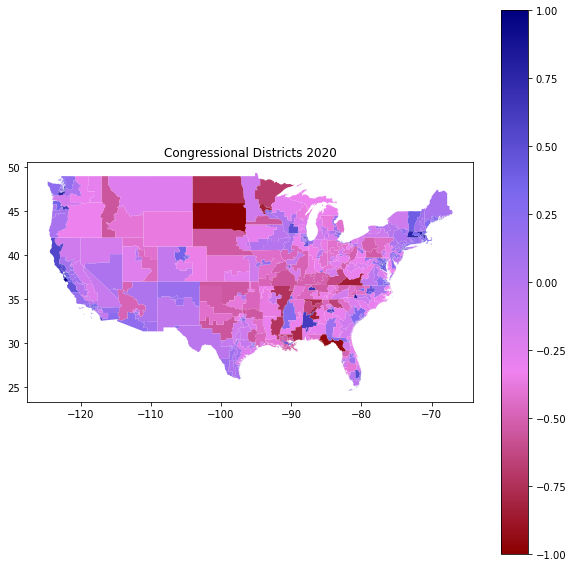

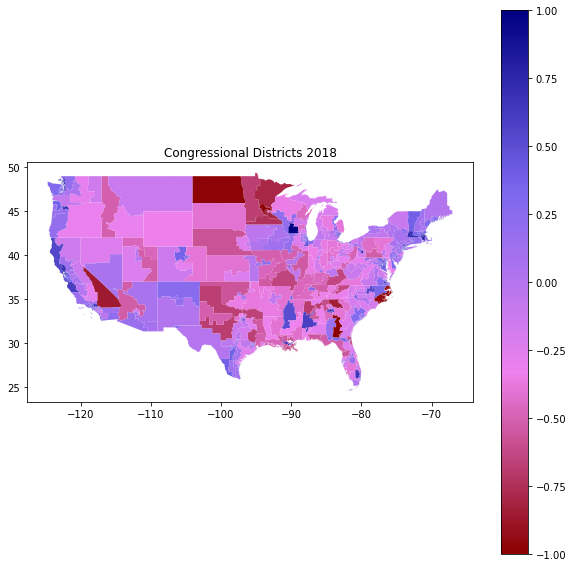

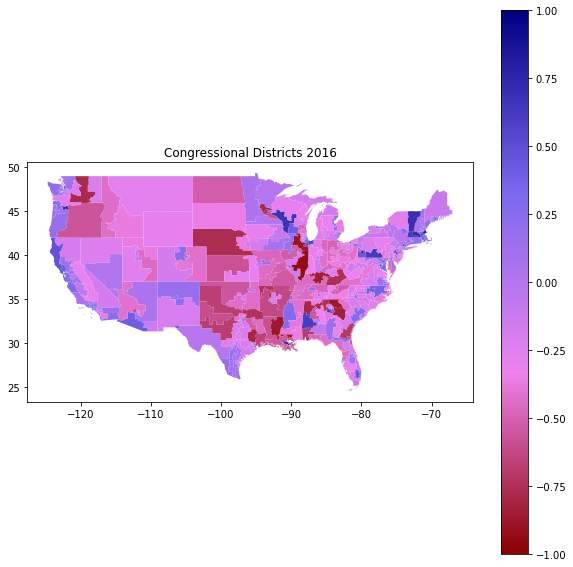

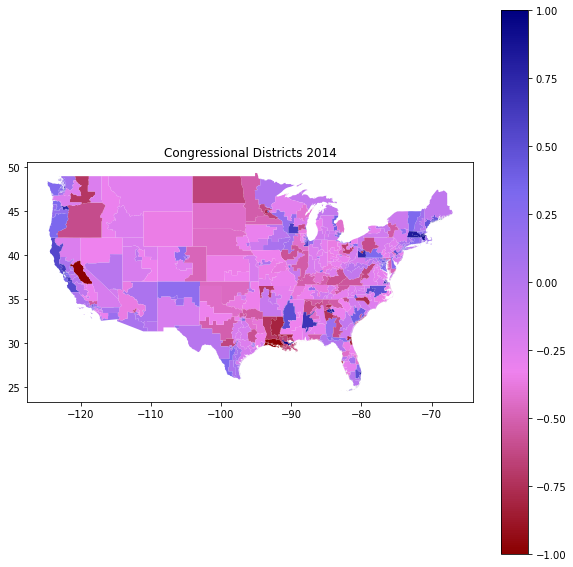

In [37]:
import matplotlib.pyplot as plt


def DisplayMap(ly, year):

    #make a colormap red to violet to purple to blue
    cm1 = mcol.LinearSegmentedColormap.from_list("MyCmapName",["darkred", "violet", "mediumslateblue", "navy"])

    #plot the map
    ly.plot(column="value", cmap=cm1, legend=True, figsize=(10, 10))
    plt.title("Congressional Districts " + str(year))
    plt.savefig(str(year) + ".png")




def main():
    for year in [2020, 2018, 2016, 2014]:
        congress = csv[csv["year"] == year]
        val = process(congress)
        dists = get_value(val)
        normalize(dists)
        DisplayMap(ly, year)

if __name__ == "__main__":
    main()